In [1]:
import pyopencl as cl
import numpy as np
import pylab

import scipy
import PIL
import PIL.Image as im
from scipy import ndimage
from PIL import ImageEnhance
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_img_large_small(imgpath = '../result_large.JPG'):
    # Read in images, im_orig is a large image, im is a small one.
    im_orig = scipy.misc.imread(imgpath,flatten=True)
    # Use a small image to test (by 12*12)
    im_small = np.array([im_orig[i][::12] for i in range(len(im_orig)) if i%12==0])
    return im_orig, im_small

def histogram(im):
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), histogram)
    plt.xlim([0,256])
    plt.show()
    #return histogram

def hist_np(im_input,nbr_bins=256):
    im = im_input.astype(int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    plt.bar(bins[:-1], imhist)
    plt.xlim([0,256])

def cumhist(im_input):
    im = im_input.astype(int)
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j<0:
                j=0
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), np.cumsum(histogram))
    plt.xlim([0,256])
    plt.ylim([0,1])
    plt.show()
    
def cumhist_np(im_input,nbr_bins=256):
    im = im_input.astype(int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    plt.bar(bins[:-1], imhist.cumsum())
    plt.xlim([0,256])
    plt.ylim([0,1])
    
def round_up(global_size, group_size):
    r = global_size % group_size
    if r == 0:
        return global_size
    return global_size + group_size - r

def normalize(img):
    return img/(np.max(img)-np.min(img))*256

In [3]:
show = lambda img: plt.imshow(img.astype(int))
gshow = lambda img: plt.imshow(img.astype(int), cmap = plt.get_cmap('gray'))
rgb2gray = lambda rgb: np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [4]:
im_orig, im_small = read_img_large_small('../result_large.jpg')

In [5]:
im_orig.shape

(2432, 3648)

In [6]:
im_small.shape

(203, 304)

##0. Original images

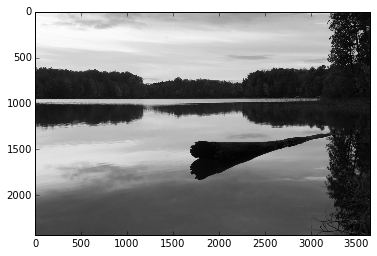

In [110]:
gshow(im_orig)
scipy.misc.imsave('im_orig.jpg', im_orig)

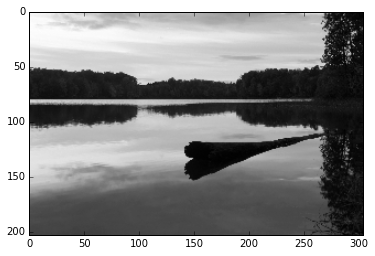

In [111]:
gshow(im_small)
scipy.misc.imsave('im_small.jpg', im_small)

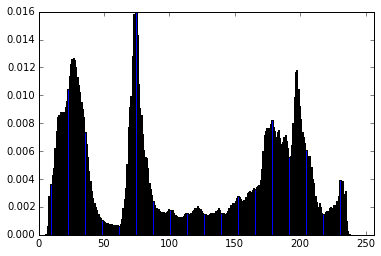

CPU times: user 3.1 s, sys: 167 ms, total: 3.26 s
Wall time: 3.07 s


In [112]:
%%time
histogram(im_orig.astype(int))

In [114]:
im_small.shape

(203, 304)

CPU times: user 324 ms, sys: 17.1 ms, total: 341 ms
Wall time: 344 ms


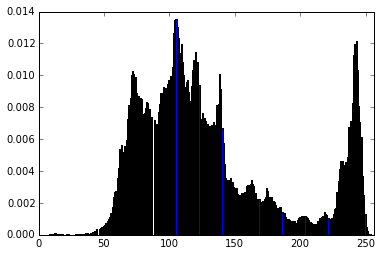

In [10]:
%%time
hist_np(im_orig.astype(int))

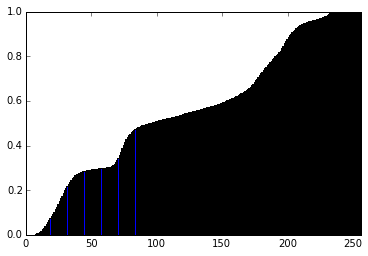

CPU times: user 4.76 s, sys: 289 ms, total: 5.05 s
Wall time: 4.74 s


In [115]:
%%time
cumhist(im_orig.astype(int))

CPU times: user 427 ms, sys: 109 ms, total: 536 ms
Wall time: 489 ms


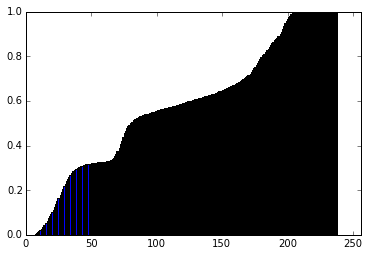

In [116]:
%%time
cumhist_np(im_orig.astype(int))

##1. HE_serial

In [117]:
def HE_serial(im_in):
    im = im_in.astype(int).copy()
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    cum_hist = np.cumsum(histogram)
    equal_hist = (cum_hist*256).astype(int)
    mapfunc = dict(zip(range(256), equal_hist))
    new_im = np.zeros_like(im)
    for i in range(height):
        for j in range(width):
            new_im[i,j] = mapfunc[im[i,j]]
    
    return new_im

In [118]:
%%time
he_serial_orig = HE_serial(im_orig)

CPU times: user 5.4 s, sys: 274 ms, total: 5.67 s
Wall time: 5.36 s


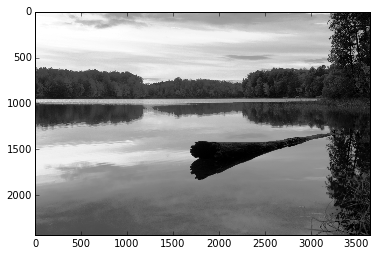

In [119]:
gshow(he_serial_orig)
scipy.misc.imsave('he_serial_orig.jpg', he_serial_orig)

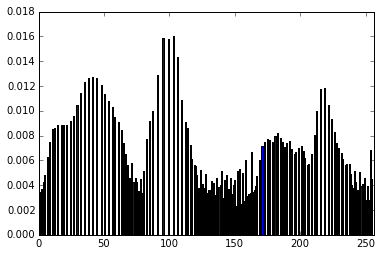

In [120]:
hist_np(he_serial_orig)

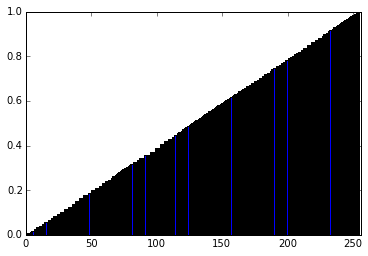

In [121]:
cumhist_np(he_serial_orig)

In [127]:
%%time
he_serial_small = HE_serial(im_small)

CPU times: user 39.4 ms, sys: 3.9 ms, total: 43.3 ms
Wall time: 38.8 ms


##2. HE_numpy

In [122]:
def HE_numpy(im_input,nbr_bins=256):
    im = im_input.astype(int)
    #get image histogram
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize

    #use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)

    return im2.reshape(im.shape)

In [123]:
%%time
he_numpy_orig = HE_numpy(im_orig)

CPU times: user 360 ms, sys: 102 ms, total: 462 ms
Wall time: 428 ms


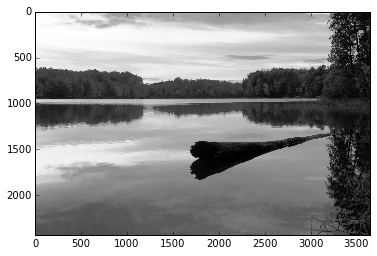

In [124]:
gshow(he_numpy_orig)
scipy.misc.imsave('he_numpy_orig.jpg', he_numpy_orig)

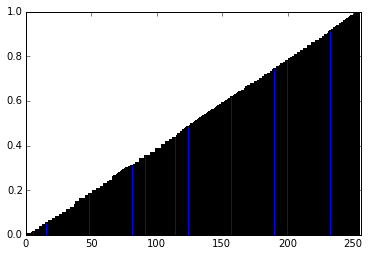

In [125]:
cumhist_np(he_numpy_orig)

In [128]:
%%time
he_numpy_small = HE_numpy(im_small)

CPU times: user 3.25 ms, sys: 802 µs, total: 4.05 ms
Wall time: 3.19 ms


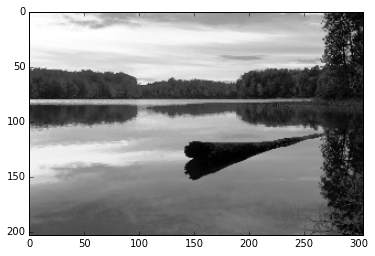

In [129]:
gshow(he_numpy_small)
scipy.misc.imsave('he_numpy_small.jpg', he_numpy_small)

##3. LHE_serial

In [130]:
def LHE_serial(im_input):
    gain = lambda s,A,S0: A-A/S0*s if A-A/S0*s>1 else 1
    im = im_input.astype(int).copy()
    height, width = im.shape
    im = np.pad(im, 4, mode='edge')
    new = np.zeros([height,width])
    for h in range(4,height+4):
        for w in range(4, width+4):
            window = im[h-4:h+5,w-4:w+5]
            old = im[h,w]
            M = np.mean(window)
            S = np.std(window)
            G = gain(S,20,10)
#             B = 0
#             if S*G-M>0:
#                 B = G*S-M
#             if S*G+M>255:
#                 B =(M+G*S)-255
            B=(128-M)*0.25
            N = (old-M)*G+B+M
            #if w==20:
                #print old,M,S,G,B,N
            if N>255:
                new[h-4,w-4]=255
            elif N<0:
                new[h-4,w-4]=0
            else:
                new[h-4,w-4]=N
    return new.astype(int)

In [135]:
%%time
lhe_serial_small = LHE_serial(im_small)

CPU times: user 2.74 s, sys: 195 ms, total: 2.93 s
Wall time: 2.69 s


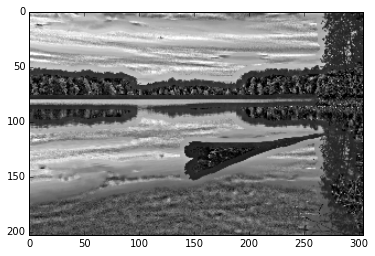

In [136]:
gshow(lhe_serial_small)
scipy.misc.imsave('lhe_serial_small.jpg', lhe_serial_small)

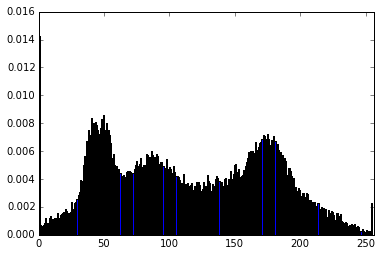

In [137]:
hist_np(lhe_serial_small)

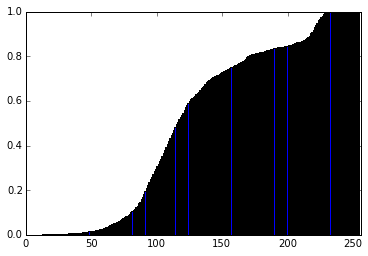

In [134]:
cumhist_np(lhe_serial_small)

##4. AHE serial

In [155]:
def AHE_serial(im_input, windowwidth=21):
    im = im_input.astype(int).copy()
    height, width = im.shape
    new = np.zeros([height,width])
    d = windowwidth/2
    
    for h in range(height):
        for w in range(width):
            cur = im[h,w]
            window = im[h-d if h-d>-1 else 0:h+d+1 if h+d+1<height else height,
                        w-d if w-d>-1 else 0:w+d+1 if w+d+1<width else width]
            flat = [i for sub in window for i in sub]
            flat = flat + random.sample(flat+flat+flat+flat, windowwidth*windowwidth-len(flat))
            idx = np.sort(np.array(flat)).tolist().index(cur)
            
            new[h,w] = int(idx*1.0/windowwidth/windowwidth*256)
    return new

In [156]:
%%time
ahe_serial_small = AHE_serial(im_small)

CPU times: user 10.5 s, sys: 609 ms, total: 11.1 s
Wall time: 10.3 s


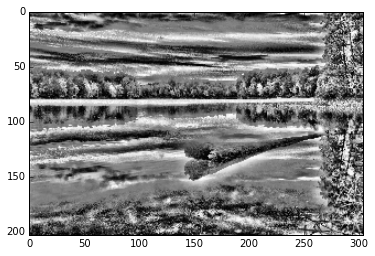

In [157]:
gshow(ahe_serial_small)
scipy.misc.imsave('ahe_serial.jpg', ahe_serial)

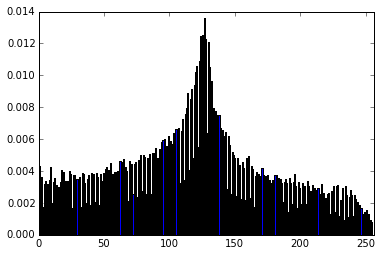

In [158]:
hist_np(ahe_serial_small)

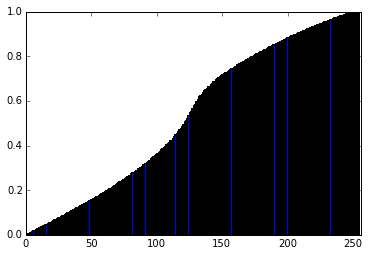

In [159]:
cumhist_np(ahe_serial_small)

##5. AHE_CL_buffer

In [153]:
def run_AHE_cl(img,clfile = 'HE.cl',windowsize=21,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()

    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)
    
    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'This context is associated with ', len(context.devices), 'devices'
        print 'The queue is using the device:', queue.device.name



    program = cl.Program(context, open(clfile).read()).build(options='')
    
    AHE_out = np.zeros_like(img)

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, AHE_out.size * 4)

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])


    pad_size = np.int32(windowsize/2)
    # Set up a (N+8 x N+8) local memory buffer.
    # +2 for 1-pixel halo on all sides, 4 bytes for float.
    local_memory = cl.LocalMemory(4 * (local_size[0] + pad_size) * (local_size[1] + pad_size))
    # Each work group will have its own private buffer.
    buf_width = np.int32(local_size[0] + 2*pad_size)
    buf_height = np.int32(local_size[1] + 2*pad_size)
    halo = np.int32(pad_size)

    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])

    #max_iters = np.int32(1024)

    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)

    event = program.AHE_buffer(queue, global_size, local_size,
                           gpu_im, gpu_out, local_memory,
                           width, height,
                           buf_width, buf_height, halo,2*pad_size+1)

    cl.enqueue_copy(queue, AHE_out, gpu_out, is_blocking=True)

    seconds = (event.profile.end - event.profile.start) / 1e9

    gshow(AHE_out.astype(int))
    print "------------------------------------------"
    print "AHE serial image with size: ", img.shape
    print "Window size: ", windowsize
    print "Used time: ", seconds
    print "------------------------------------------"
    
    return AHE_out

------------------------------------------
AHE serial image with size:  (203, 304)
Window size:  21
Used time:  0.00396824
------------------------------------------


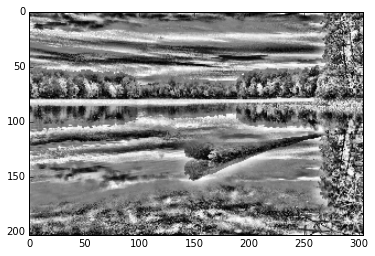

In [154]:
ahe_cl = run_AHE_cl(im_small)

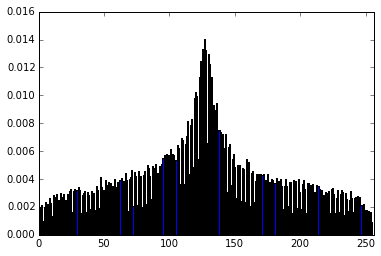

In [160]:
hist_np(ahe_cl)

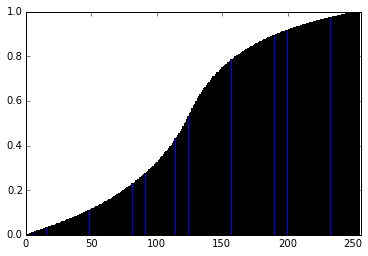

In [43]:
cumhist_np(ahe_cl)

In [161]:
scipy.misc.imsave('ahe_cl.jpg', ahe_cl)

------------------------------------------
AHE serial image with size:  (2432, 3648)
Window size:  21
Used time:  0.39071936
------------------------------------------


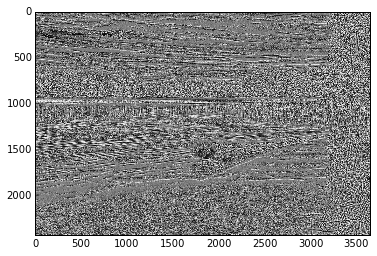

In [162]:
ahe_cl_orig = run_AHE_cl(im_orig)

In [163]:
scipy.misc.imsave('ahe_cl_orig.jpg', ahe_cl_orig)

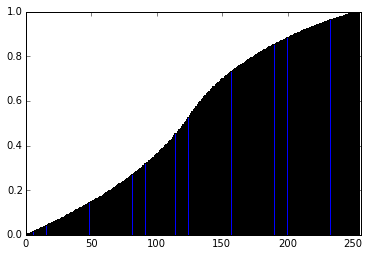

In [164]:
cumhist_np(ahe_cl_orig)

##6. AHE_interpolation

In [241]:
def run_AHE_Interpolation_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    #local_memory = cl.LocalMemory(4 * local_size[0]*local_size[1])
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
#     gshow(normalize(img_out).astype(int))
#     print "------------------------------------------"
#     print "AHE serial on image with size: ", img.shape
#     print "Segmentation size (on each side): ", segmentationsize
#     print "Used time: 1. histogram calculation: ", time1 *1000, ' ms'
#     print "Used time: 2. transformation: ", time2 *1000, ' ms'
#     print "Used time: 3. total: ", time1*1000+time2 *1000, ' ms'
#     print "------------------------------------------"
    print time1*1000,'\t',time2 *1000
    
    return img_out

(12, 3072)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  199.35904  ms
Used time: 2. transformation:  7.67032  ms
Used time: 3. total:  207.02936  ms
------------------------------------------


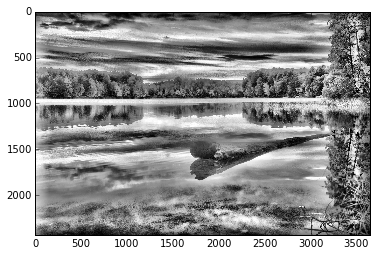

In [184]:
ahe_inter = run_AHE_Interpolation_cl(im_orig)

In [170]:
scipy.misc.imsave('ahe_inter.jpg', ahe_inter)

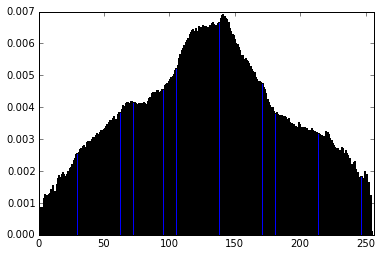

In [171]:
hist_np(ahe_inter[0])

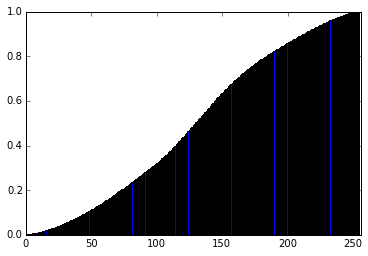

In [172]:
cumhist_np(ahe_inter)

(12, 3072)
------------------------------------------
AHE serial on image with size:  (203, 304)
Used time: 1. histogram calculation:  0.00041576
Used time: 2. transformation:  7.736e-05
Used time: 3. total:  0.00049312
------------------------------------------


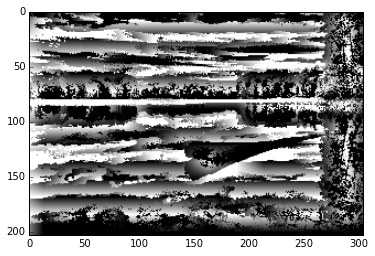

In [173]:
ahe_inter_small = run_AHE_Interpolation_cl(im_small)

In [248]:
ahe_inter2 = run_AHE_Interpolation_cl(im_orig,segmentationsize=36)

(36, 9216)
110.9908 	7.81456


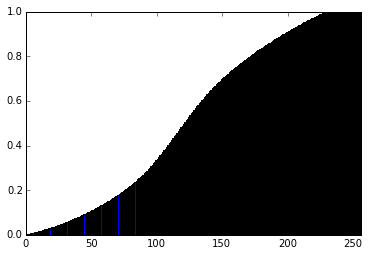

In [189]:
cumhist_np(ahe_inter2[0]/np.max(ahe_inter2)*256)

(1, 256)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  1
Used time: 1. histogram calculation:  265.08328  ms
Used time: 2. transformation:  7.56576  ms
Used time: 3. total:  272.64904  ms
------------------------------------------


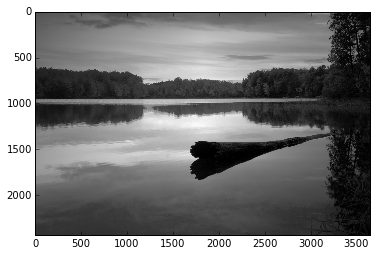

In [190]:
ahe_inter1 = run_AHE_Interpolation_cl(im_orig,segmentationsize=1)

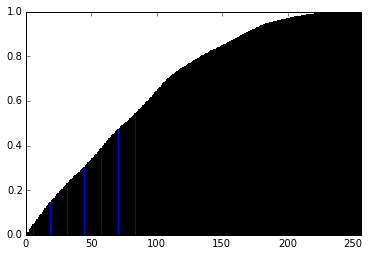

In [57]:
cumhist_np(ahe_inter1[0]/np.max(ahe_inter1)*256)

(24, 6144)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  24
Used time: 1. histogram calculation:  138.416  ms
Used time: 2. transformation:  7.72024  ms
Used time: 3. total:  146.13624  ms
------------------------------------------


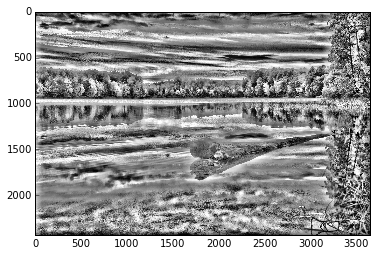

In [191]:
ahe_inter24 = run_AHE_Interpolation_cl(im_orig,segmentationsize=24)

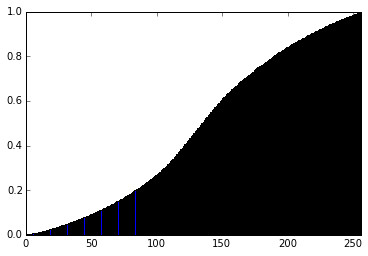

In [192]:
cumhist_np(ahe_inter24[0]/np.max(ahe_inter24[0])*256)

(8, 2048)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  8
Used time: 1. histogram calculation:  218.3364  ms
Used time: 2. transformation:  7.57056  ms
Used time: 3. total:  225.90696  ms
------------------------------------------


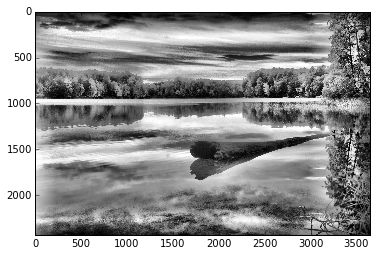

In [193]:
ahe_inter8 = run_AHE_Interpolation_cl(im_orig,segmentationsize=8)

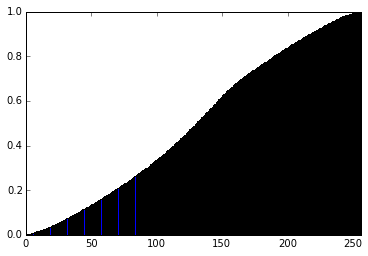

In [194]:
cumhist_np(ahe_inter8[0]/np.max(ahe_inter8)*256)

(12, 3072)
------------------------------------------
AHE serial on image with size:  (203, 304)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  0.42208  ms
Used time: 2. transformation:  0.07912  ms
Used time: 3. total:  0.5012  ms
------------------------------------------


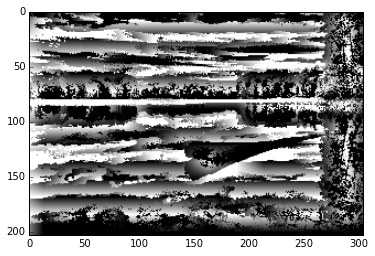

In [195]:
ahe_inter_12_small = run_AHE_Interpolation_cl(im_small)

##7. Interpolation buffer

In [251]:
def run_AHE_Interpolation_buffer_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (16, 32)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    
    local_memory = cl.LocalMemory(256*4*4+2*4) # store the mapping histogram into the buffer
    
    
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform_buffer(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out, local_memory,
                                           width, height,seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
    gshow(normalize(img_out).astype(int))
    print "------------------------------------------"
    print "AHE serial on image with size: ", img.shape
    print "Segmentation size (on each side): ", segmentationsize
    print "Used time: 1. histogram calculation: ", time1 *1000, ' ms'
    print "Used time: 2. transformation: ", time2 *1000, ' ms'
    print "Used time: 3. total: ", time1*1000+time2 *1000, ' ms'
    print "------------------------------------------"
    
    return img_out

(12, 3072)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  237.80672  ms
Used time: 2. transformation:  263.1556  ms
Used time: 3. total:  500.96232  ms
------------------------------------------


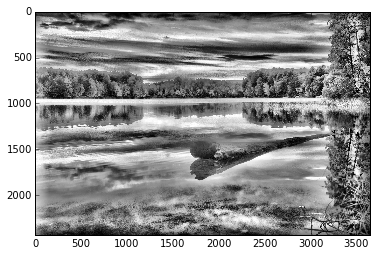

In [252]:
ahe_inter_buffer = run_AHE_Interpolation_buffer_cl(im_orig,segmentationsize=12)

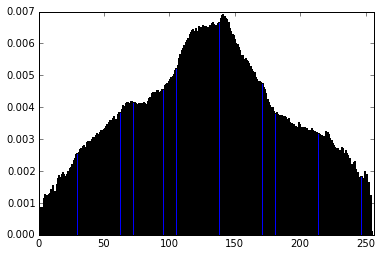

In [200]:
hist_np(ahe_inter_buffer)

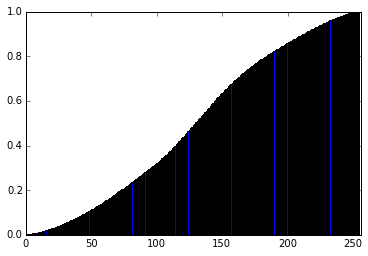

In [201]:
cumhist_np(ahe_inter_buffer)

(12, 3072)
------------------------------------------
AHE serial on image with size:  (203, 304)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  0.42904  ms
Used time: 2. transformation:  3.30296  ms
Used time: 3. total:  3.732  ms
------------------------------------------


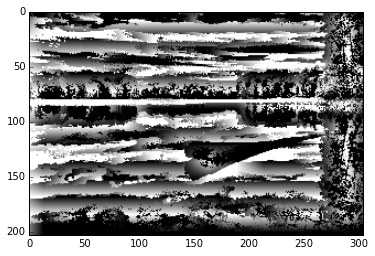

In [205]:
ahe_inter_buffer_small = run_AHE_Interpolation_buffer_cl(im_small,segmentationsize=12)

##8. Better data structure

In [213]:
def run_AHE_Interpolation_buffer_smaller_256_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    
    local_memory = cl.LocalMemory(256*4) # store the mapping histogram into the buffer
    
    
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform_buffer_small_256(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out, local_memory,
                                           width, height,seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
    gshow(normalize(img_out).astype(int))
    print "------------------------------------------"
    print "AHE serial on image with size: ", img.shape
    print "Segmentation size (on each side): ", segmentationsize
    print "Used time: 1. histogram calculation: ", time1 *1000, ' ms'
    print "Used time: 2. transformation: ", time2 *1000, ' ms'
    print "Used time: 3. total: ", time1*1000+time2 *1000, ' ms'
    print "------------------------------------------"
    
    return img_out

(12, 3072)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  191.29048  ms
Used time: 2. transformation:  302.83328  ms
Used time: 3. total:  494.12376  ms
------------------------------------------


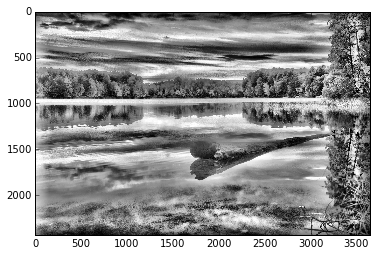

In [214]:
ahe_cl_buffer_256 = run_AHE_Interpolation_buffer_smaller_256_cl(im_orig)

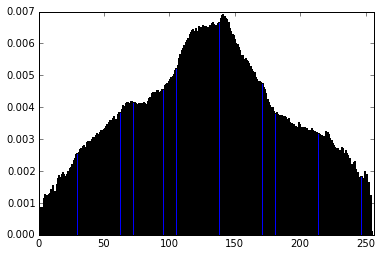

In [215]:
hist_np(ahe_cl_buffer_256)

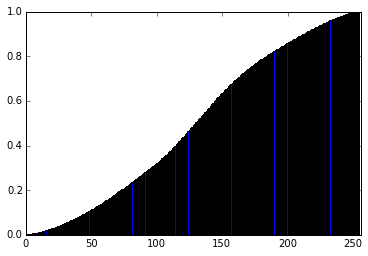

In [216]:
cumhist_np(ahe_cl_buffer_256)

(12, 3072)
------------------------------------------
AHE serial on image with size:  (203, 304)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  0.4096  ms
Used time: 2. transformation:  2.1324  ms
Used time: 3. total:  2.542  ms
------------------------------------------


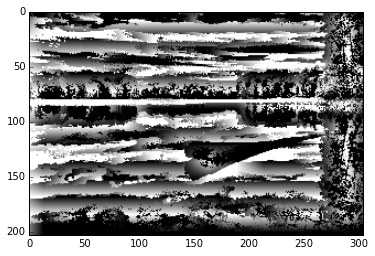

In [217]:
ahe_cl_buffer_256_small = run_AHE_Interpolation_buffer_smaller_256_cl(im_small)

In [224]:
def run_AHE_Interpolation_buffer_smaller_32_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    
    local_memory = cl.LocalMemory(32*4+2) # store the mapping histogram into the buffer
    
    
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform_buffer_small_32(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out, local_memory,
                                           width, height,seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
    gshow(normalize(img_out).astype(int))
    print "------------------------------------------"
    print "AHE serial on image with size: ", img.shape
    print "Segmentation size (on each side): ", segmentationsize
    print "Used time: 1. histogram calculation: ", time1 *1000, ' ms'
    print "Used time: 2. transformation: ", time2 *1000, ' ms'
    print "Used time: 3. total: ", time1*1000+time2 *1000, ' ms'
    print "------------------------------------------"
    
    return img_out

(12, 3072)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  197.19608  ms
Used time: 2. transformation:  166.97552  ms
Used time: 3. total:  364.1716  ms
------------------------------------------


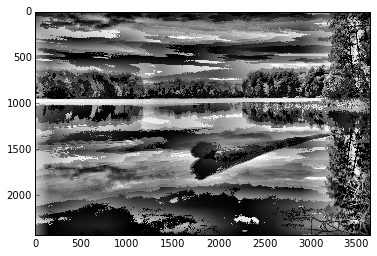

In [225]:
ahe_cl_buffer_32_orig = run_AHE_Interpolation_buffer_smaller_32_cl(im_orig)

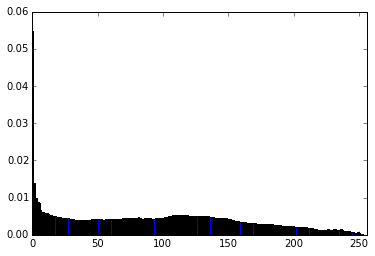

In [226]:
hist_np(ahe_cl_buffer_32_orig)

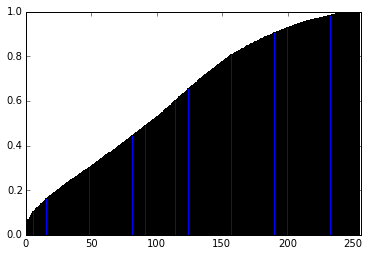

In [227]:
cumhist_np(ahe_cl_buffer_32_orig)

(12, 3072)
------------------------------------------
AHE serial on image with size:  (203, 304)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  0.41928  ms
Used time: 2. transformation:  1.60344  ms
Used time: 3. total:  2.02272  ms
------------------------------------------


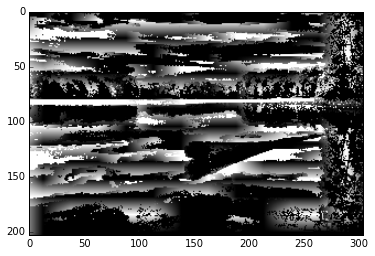

In [239]:
ahe_cl_buffer_32_small = run_AHE_Interpolation_buffer_smaller_32_cl(im_small)

##9. Avoiding bank conflict

In [7]:
def run_AHE_Interpolation_buffer_smaller_256_bank_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    
    local_memory = cl.LocalMemory(257*4) # store the mapping histogram into the buffer
    
    
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform_buffer_small_256_bank(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out, local_memory,
                                           width, height,seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
    gshow(normalize(img_out).astype(int))
    print "------------------------------------------"
    print "AHE serial on image with size: ", img.shape
    print "Segmentation size (on each side): ", segmentationsize
    print "Used time: 1. histogram calculation: ", time1 *1000, ' ms'
    print "Used time: 2. transformation: ", time2 *1000, ' ms'
    print "Used time: 3. total: ", time1*1000+time2 *1000, ' ms'
    print "------------------------------------------"
    
    return img_out

(12, 3072)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  202.76224  ms
Used time: 2. transformation:  285.1396  ms
Used time: 3. total:  487.90184  ms
------------------------------------------


/Users/haosutang/anaconda/lib/python2.7/site-packages/pyopencl/__init__.py:206: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


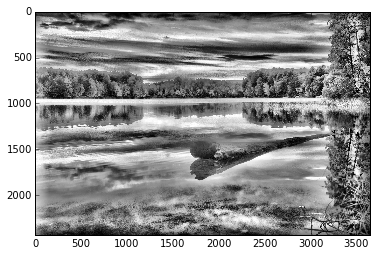

In [8]:
ahe_cl_buffer_256_orig_bank = run_AHE_Interpolation_buffer_smaller_256_bank_cl(im_orig)

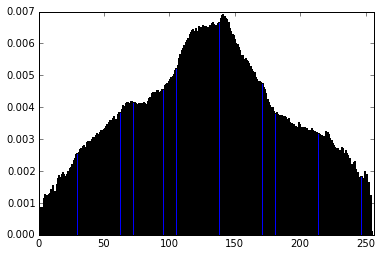

In [236]:
hist_np(ahe_cl_buffer_256_orig_bank)

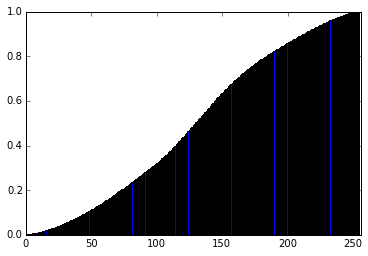

In [237]:
cumhist_np(ahe_cl_buffer_256_orig_bank)

(12, 3072)
------------------------------------------
AHE serial on image with size:  (203, 304)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  0.43032  ms
Used time: 2. transformation:  2.12488  ms
Used time: 3. total:  2.5552  ms
------------------------------------------


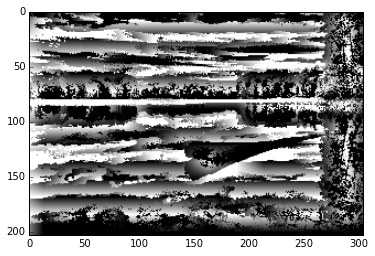

In [238]:
ahe_cl_buffer_256_small_bank = run_AHE_Interpolation_buffer_smaller_256_bank_cl(im_small)

##10. Improving buffer

In [17]:
def run_AHE_Interpolation_buffer_smaller_256_bank_cl_mod(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (16,32)  # 512 workers
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    
    local_memory = cl.LocalMemory(257*4) # store the mapping histogram into the buffer
    
    
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform_buffer_small_256_bank_mod(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out, local_memory,
                                           width, height,seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
    gshow(normalize(img_out).astype(int))
    print "------------------------------------------"
    print "AHE serial on image with size: ", img.shape
    print "Segmentation size (on each side): ", segmentationsize
    print "Used time: 1. histogram calculation: ", time1 *1000, ' ms'
    print "Used time: 2. transformation: ", time2 *1000, ' ms'
    print "Used time: 3. total: ", time1*1000+time2 *1000, ' ms'
    print "------------------------------------------"
    
    return img_out

(12, 3072)
------------------------------------------
AHE serial on image with size:  (2432, 3648)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  236.32184  ms
Used time: 2. transformation:  163.53752  ms
Used time: 3. total:  399.85936  ms
------------------------------------------


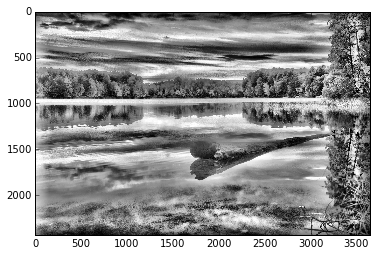

In [18]:
ahe_cl_buffer_256_small_bank_mod = run_AHE_Interpolation_buffer_smaller_256_bank_cl_mod(im_orig)

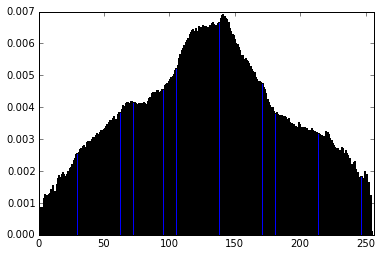

In [14]:
hist_np(ahe_cl_buffer_256_small_bank_mod)

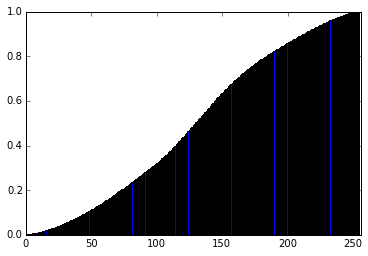

In [15]:
cumhist_np(ahe_cl_buffer_256_small_bank_mod)

(12, 3072)
------------------------------------------
AHE serial on image with size:  (203, 304)
Segmentation size (on each side):  12
Used time: 1. histogram calculation:  0.42768  ms
Used time: 2. transformation:  1.51344  ms
Used time: 3. total:  1.94112  ms
------------------------------------------


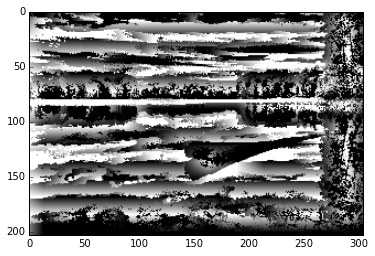

In [16]:
ahe_cl_buffer_256_small_bank_mod_small = run_AHE_Interpolation_buffer_smaller_256_bank_cl_mod(im_small)